## Project 4 - Kaggle Competition Starter Code (West Nile Virus Detection)

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pdp

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier



# display plots in the notebook
%matplotlib inline
# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 12

In [2]:
#taking an initial look at the data set

In [541]:
train = pd.read_csv("../assets/train.csv")

In [542]:
# Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across 
# the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for 
# the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, 
# the mosquitos species, and whether or not West Nile virus is present in the cohort. 

# These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into 
# another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

# The location of the traps are described by the block number and street name. For your convenience, we have mapped 
# these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. 
# For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL",
# which translates to (41.974089,-87.824812) on the map.

# Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap 
# to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap 
# to T220 

# Please note that not all the locations are tested at all times. Also, records exist only when a particular species 
# of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations / 
# permutations of possible predictions and are only scoring the observed ones.

# train.csv, test.csv - the training and test set of the main dataset. The training set consists of data from 
# 2007, 2009, 2011, and 2013, while in the test set you are requested to predict the test results for 2008, 2010, 2012, 
# and 2014.
# Id: the id of the record
# Date: date that the WNV test is performed
# Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
# Species: the species of mosquitos
# Block: block number of address
# Street: street name
# Trap: Id of the trap
# AddressNumberAndStreet: approximate address returned from GeoCoder
# Latitude, Longitude: Latitude and Longitude returned from GeoCoder
# AddressAccuracy: accuracy returned from GeoCoder
# NumMosquitos: number of mosquitoes caught in this trap
# WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 

train

#WnvPresent is clearly the target variable here. 
#will need to convert date column to date_time

#Could first two rows be duplicates? Their only difference is in species - different species from the same trap? Probably
#how often do mosquitos of different species in the same trap all carry wnv?
#does one species of mosquito carry wnv more than others?

#We'll need to match the spraying data with the data on which traps are checked, and then look at whether wnv reappears
#if it was previously present

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0


In [543]:
train.describe(include="all")
#pdp.ProfileReport(train)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506,10506,10506,10506.000000,10506,10506,10506,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
unique,95,138,7,NaN,128,136,138,NaN,NaN,NaN,NaN,NaN
top,2007-08-01,"ORD Terminal 5, O'Hare International Airport, ...",CULEX PIPIENS/RESTUANS,NaN,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",NaN,NaN,NaN,NaN,NaN
freq,551,750,4752,NaN,750,750,750,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,35.687797,NaN,NaN,NaN,41.841139,-87.699908,7.819532,12.853512,0.052446
std,NaN,NaN,NaN,24.339468,NaN,NaN,NaN,0.112742,0.096514,1.452921,16.133816,0.222936
min,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,NaN,NaN,NaN,12.000000,NaN,NaN,NaN,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,NaN,NaN,NaN,33.000000,NaN,NaN,NaN,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,NaN,NaN,NaN,52.000000,NaN,NaN,NaN,41.954690,-87.627796,9.000000,17.000000,0.000000


In [544]:
train.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

In [545]:
#converting Date to datatime format
train["Date"] = pd.to_datetime(train["Date"], infer_datetime_format=True)

In [546]:
#Creating a separate column for "year" for ease of reading and later filtering
train["Year"] = train["Date"].dt.year


In [547]:
#Commented this section out, as we're now combining all rows with the same date, trap, and species (see below)

# #Examining duplicate rows.
# dup_rows = train[train.duplicated()] 
# dup_rows.groupby("NumMosquitos").NumMosquitos.count()

# #Most of the duplicates (707) had 50 mosquitos, which makes sense. If more than 50 mosquitos were detected from a given
# #sample, another row would be added to the data set to account for any additional mosquitos. Presumably, most of the 
# #duplicates with 50 mosquito counts had more than 100 mosquitos in them at the time they were collected. I think 
# #we can safely drop all of the duplicates with fewer than 50 mosquitos, as traps are only collected once per week,
# #so there should be no instances in which a trap would be checked twice in the same day and have the same small
# #number of mosquitos inside.

# #assembling rows to drop
# mos_less_50 = train[train["NumMosquitos"] < 50]
# drop_rows = mos_less_50[mos_less_50.duplicated]

# #dropping 106 duplicate rows with fewer than 50 mos from train set
# train = train[~train.isin(drop_rows)].dropna(how='all')


In [548]:
train.isnull().sum()
#no null values to worry about.

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
Year                      0
dtype: int64

In [549]:
#Creating "Parent Trap" column that will indicate all traps associated with a parent trap (e.g., T002A would be T002)
train["Parent_Trap"] = train["Trap"].str[:4]

#creating column to indicate if trap is satellite (1) or not (0) 
train["Is_Satellite"] = 1.0

train.ix[train["Trap"] == train["Parent_Trap"], "Is_Satellite"] = 0.0
#train.ix[train["Is_Satellite"] == "", "Is_Satellite"] = 1.0

train.groupby("Is_Satellite").Is_Satellite.count()
#there are barely any records of satellite traps - only 14 in the entire dataset?
#After examining the data, there are only two satellite traps in the train set - T054C and T094B


Is_Satellite
0.0    10492
1.0       14
Name: Is_Satellite, dtype: int64

In [550]:
#For ease of data use, dropping Address, Block, Street, AddressNumberAndStreet, AddressAccuracy from Train
train.drop(["Address", "Block", "Street", "AddressNumberAndStreet", "AddressAccuracy"], axis=1, inplace=True)


In [551]:
train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,2007,T002,0.0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,2007,T002,0.0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,2007,T007,0.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,2007,T015,0.0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,2007,T015,0.0


In [552]:
#Finding which traps are associated with more than one pair of latitude and longitude:
dup_lat = train.groupby(["Trap", "Longitude"]).Latitude.count().unstack()

#filling in NaN values with 0
dup_lat.fillna(value=0.0, inplace=True) 

#counting number of non-zero cells in each row, and generating a separate column of these counts:
#sourced from https://stackoverflow.com/questions/29229600/counting-number-of-zeros-per-row-by-pandas-dataframe
dup_lat["distinct"] = (dup_lat != 0).sum(axis=1)

#filtering to show only rows where more than one latitude is recorded for any trap
dup_lat = dup_lat[dup_lat["distinct"] > 1]

#removing all columns with all zeros to better see values of coordinate pairs:
#sourced from https://stackoverflow.com/questions/21164910/delete-column-in-pandas-based-on-condition
dup_lat = dup_lat.loc[:, (dup_lat != 0).any(axis=0)]

print("Traps with more than one pair of associated Lat/Long coordinates: ")
print
print(dup_lat)
print
#two traps (T009 and T035) are associated with more than one pair of long/lat coordinates - perhaps they were replaced
#in different years? I also confirmed that grouping by Trap and Latitude and counting Longitude produced the same 
#results.

#Checking years for which the two multi-coordinate traps had each pair of coordinates
print("Longitude Coordinates of Trap T009 by Year: ")
print(train[train.Trap == "T009"].groupby("Year").Longitude.value_counts())
print
print("Longitude Coordinates of Trap T035 by Year: ")
print(train[train.Trap == "T035"].groupby("Year").Longitude.value_counts())

#It looks like both traps had different coordinates in 2007 than in 2009 (at least for T009), 2011, and 2013. We'll
#have to look at the test data to see when these traps had different coordinates. (likely either 2008 or 2009.)

Traps with more than one pair of associated Lat/Long coordinates: 

Longitude  -87.862995  -87.812827  -87.742302  -87.677737  distinct
Trap                                                               
T009             80.0        31.0         0.0         0.0         2
T035              0.0         0.0        45.0        27.0         2

Longitude Coordinates of Trap T009 by Year: 
Year  Longitude 
2007  -87.812827    31
2009  -87.862995    27
2011  -87.862995    12
2013  -87.862995    41
Name: Longitude, dtype: int64

Longitude Coordinates of Trap T035 by Year: 
Year  Longitude 
2007  -87.677737    27
2011  -87.742302    18
2013  -87.742302    27
Name: Longitude, dtype: int64


In [553]:
sorted(train.Date.unique())

[numpy.datetime64('2007-05-29T00:00:00.000000000'),
 numpy.datetime64('2007-06-05T00:00:00.000000000'),
 numpy.datetime64('2007-06-26T00:00:00.000000000'),
 numpy.datetime64('2007-06-29T00:00:00.000000000'),
 numpy.datetime64('2007-07-02T00:00:00.000000000'),
 numpy.datetime64('2007-07-11T00:00:00.000000000'),
 numpy.datetime64('2007-07-18T00:00:00.000000000'),
 numpy.datetime64('2007-07-19T00:00:00.000000000'),
 numpy.datetime64('2007-07-25T00:00:00.000000000'),
 numpy.datetime64('2007-07-27T00:00:00.000000000'),
 numpy.datetime64('2007-08-01T00:00:00.000000000'),
 numpy.datetime64('2007-08-02T00:00:00.000000000'),
 numpy.datetime64('2007-08-03T00:00:00.000000000'),
 numpy.datetime64('2007-08-07T00:00:00.000000000'),
 numpy.datetime64('2007-08-08T00:00:00.000000000'),
 numpy.datetime64('2007-08-09T00:00:00.000000000'),
 numpy.datetime64('2007-08-15T00:00:00.000000000'),
 numpy.datetime64('2007-08-16T00:00:00.000000000'),
 numpy.datetime64('2007-08-17T00:00:00.000000000'),
 numpy.datet

In [554]:
#finding all rows where Date, Species, and Trap are duplicates, so that the number of mosquitos for each unique
#combination can be summed together.

#Setting "keep=False" to ensure *all* duplicates are included (normally, the first unique instance is not included)
dup_trap_spec = train[train[["Date", "Species", "Trap"]].duplicated(keep=False)] 

dup_trap_spec
#lots of duplicates here - even beyond those previously found above - different numbers of the same species
#of mosquitos in the same trap in the same day - what gives? I checked the dates, and there are many occurances
#of sequential test days (e.g., testing  '2007-08-01', '2007-08-02', and'2007-08-03'). I still have a hard time
#believing that tests are being conducted on the same trap multiple times per day.  What to do? Add all mosquitos
#from all traps of the same species, trap, and date together (without deleting duplicate rows)? If so, ensure that 
#any row with WNV present translates to the combined also indicated WNV being present.

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite
98,2007-06-26,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,1,0,2007,T086,0.0
99,2007-06-26,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,1,0,2007,T086,0.0
280,2007-07-11,CULEX RESTUANS,T015,41.974089,-87.824812,1,0,2007,T015,0.0
281,2007-07-11,CULEX RESTUANS,T015,41.974089,-87.824812,2,0,2007,T015,0.0
293,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,50,0,2007,T086,0.0
294,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,35,0,2007,T086,0.0
295,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,50,0,2007,T086,0.0
296,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,8,0,2007,T086,0.0
297,2007-07-11,CULEX RESTUANS,T086,41.688324,-87.676709,1,0,2007,T086,0.0
298,2007-07-11,CULEX RESTUANS,T086,41.688324,-87.676709,8,0,2007,T086,0.0


In [555]:
#to consolidate all rows, while summing NumMosquitos and WnvPresent, we'll need to use a grouby.sum expression.
#determining list of columns where info should be the same for every duplicate row.
mosnum_group_columns = list(dup_trap_spec.columns)
mosnum_group_columns.remove("NumMosquitos")
mosnum_group_columns.remove("WnvPresent")
print(mosnum_group_columns)

['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'Year', 'Parent_Trap', 'Is_Satellite']


In [556]:
#consolidating rows, summing NumMosquitos and WnvPresent values, using "as_index=False" to ensure all rows have 
#all appropriate values (e.g., not only having one instance of a date for all rows associated with that date)
consol_rows = pd.DataFrame(dup_trap_spec.groupby(mosnum_group_columns, as_index=False).sum())

#WnvPresent should only be 1 or 0, so any values of WnvPresent > 1.0 should be reset to 1.0
consol_rows.ix[consol_rows.WnvPresent > 1.0, "WnvPresent"] = 1.0

#ensuring only 0s and 1s for WnvPresent
print(consol_rows.WnvPresent.value_counts())

#rearranging columns in consol_rows to match order of train data
consol_rows = consol_rows[train.columns]

consol_rows.head()

0.0    608
1.0    147
Name: WnvPresent, dtype: int64


,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite
0,2007-06-26,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,2,0.0,2007,T086,0.0
1,2007-07-11,CULEX PIPIENS/RESTUANS,T016,42.011601,-87.811506,51,0.0,2007,T016,0.0
2,2007-07-11,CULEX PIPIENS/RESTUANS,T086,41.688324,-87.676709,143,0.0,2007,T086,0.0
3,2007-07-11,CULEX PIPIENS/RESTUANS,T158,41.682587,-87.707973,189,0.0,2007,T158,0.0
4,2007-07-11,CULEX RESTUANS,T011,41.944869,-87.832763,3,0.0,2007,T011,0.0


In [557]:
#dropping all original rows in dup_trap_spec from train
train = train[~train.isin(dup_trap_spec)].dropna(how='all')

#concatenating consol_rows onto bottom of train.
train = pd.concat([train, consol_rows], axis=0)

#resorting train by Date, Trap, and Species, and resetting index.
train = train.sort_values(by=['Date', "Trap", "Species"])
train.reset_index(inplace=True, drop=True)

train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1.0,0.0,2007.0,T007,0.0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1.0,0.0,2007.0,T015,0.0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4.0,0.0,2007.0,T015,0.0


In [558]:
train.shape

(8475, 10)

In [559]:
#separating out data of traps and dates for where WNV was present.
wnv_outbreaks = train[train["WnvPresent"] == 1].groupby("Date").WnvPresent.count()
#creating new dataframe from data, and generating a separate index column
wnv_outbreaks = pd.DataFrame(wnv_outbreaks)
wnv_outbreaks.reset_index(inplace=True)
wnv_outbreaks.head()

,Date,WnvPresent
0,2007-07-18,1
1,2007-07-25,2
2,2007-08-01,15
3,2007-08-02,3
4,2007-08-07,11


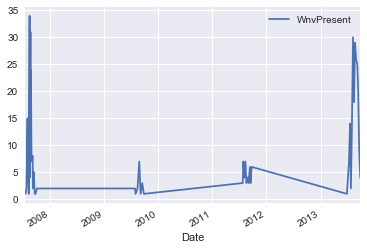

In [560]:
wnv_outbreaks.plot(x="Date", y="WnvPresent")

#definitely a lot fewer observations of wnv in 2009 and 2011 than in 2007 and 2013.  Take account of this when
#examining the y-axes of the following yearly plots

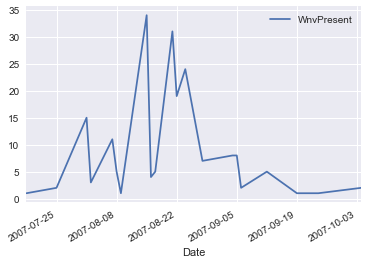

In [561]:
#plotting number of traps containing WNV in 2007
wnv_outbreaks[(wnv_outbreaks.Date > "2006-12-31") & (wnv_outbreaks.Date < "2008-01-01")].plot(x="Date", y="WnvPresent")

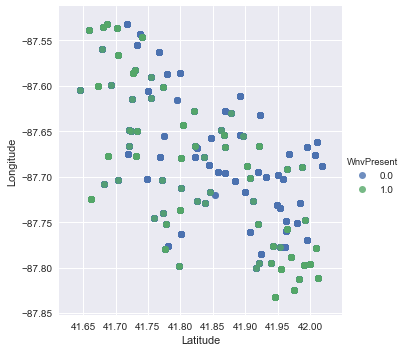

In [562]:
#scatter plot for WNV in 2007 
train_2007 = train[(train.Date > "2006-12-31") & (train.Date < "2008-01-01")]
sns.lmplot(x="Latitude", y="Longitude", data = train_2007, hue="WnvPresent", fit_reg=False)

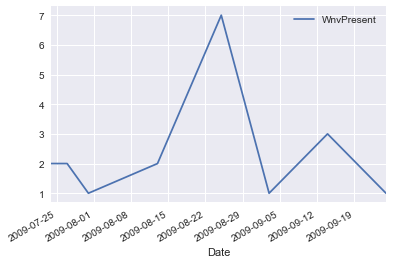

In [563]:
#plotting number of traps containing WNV in 2009
wnv_outbreaks[(wnv_outbreaks.Date > "2008-12-31") & (wnv_outbreaks.Date < "2010-01-01")].plot(x="Date", y="WnvPresent")

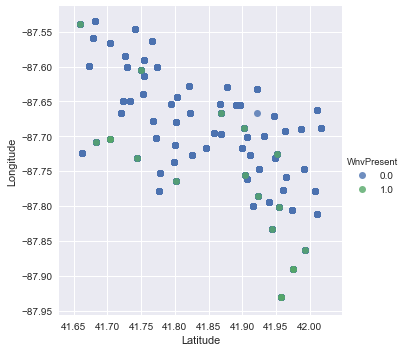

In [564]:
#scatter plot for WNV in 2009 
train_2009 = train[(train.Date > "2008-12-31") & (train.Date < "2010-01-01")]
sns.lmplot(x="Latitude", y="Longitude", data = train_2009, hue="WnvPresent", fit_reg=False)

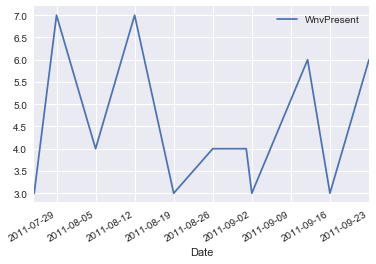

In [565]:
#plotting number of traps containing WNV in 2011
wnv_outbreaks[(wnv_outbreaks.Date > "2010-12-31") & (wnv_outbreaks.Date < "2012-01-01")].plot(x="Date", y="WnvPresent")

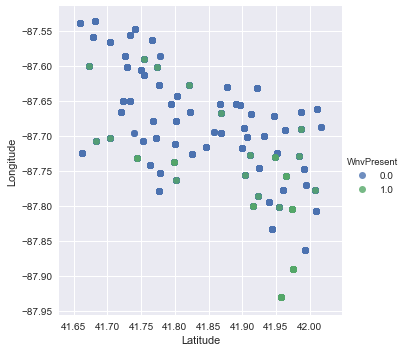

In [566]:
#scatter plot for WNV in 2011 
train_2011 = train[(train.Date > "2010-12-31") & (train.Date < "2012-01-01")]
sns.lmplot(x="Latitude", y="Longitude", data = train_2011, hue="WnvPresent", fit_reg=False)

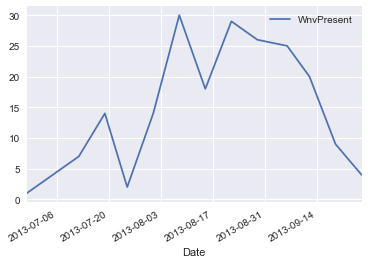

In [567]:
#plotting number of traps containing WNV in 2013
wnv_outbreaks[(wnv_outbreaks.Date > "2012-12-31") & (wnv_outbreaks.Date < "2014-01-01")].plot(x="Date", y="WnvPresent")

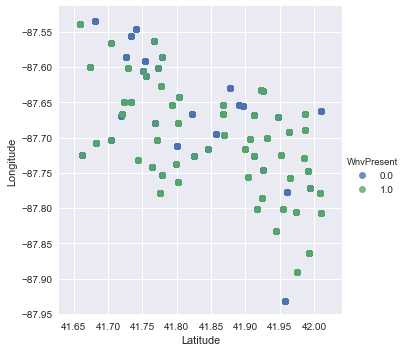

In [568]:
#scatter plot for WNV in 2013 
train_2013 = train[(train.Date > "2012-12-31") & (train.Date < "2014-01-01")]
sns.lmplot(x="Latitude", y="Longitude", data = train_2013, hue="WnvPresent", fit_reg=False)

In [569]:
#How many mosquitos were in traps when WNV was found compared to when not found?
print("Mean number of mosquitos present when WNV is absent vs. present: ")
print(train.groupby("WnvPresent").NumMosquitos.mean())
print
#on average, traps with wnv present had almost nine times as many mosquitos as those without (89.38 vs. 11.75)
#the ranges of mosquitos in both types of traps (not shown here) is from 1-50 for both conditions, so range isn't helpful

#How many mosquitos were in traps when WNV was found compared to when not found?
print("Median number of mosquitos present when WNV is absent vs. present: ")
print(train.groupby("WnvPresent").NumMosquitos.median())
print
#the median number of mosquitos in traps with wnv present almost 8 times greate than those without (23.0 vs. 3.0)
#the ranges of mosquitos in both types of traps (not shown here) is from 1-50 for both conditions, so range isn't helpful

#looking at std of number of mosquitos when WNV is absent vs. present
print("Standard deviation of mosquitos present when WNV is absent vs. present: ")
print(train.groupby("WnvPresent").NumMosquitos.std())
print

#Using mean and std, we can know how many mosquitos were in 68% of traps with and without WNV 
print("Range of Mosquitos in traps without WNV (one STD around Mean): ") 
print(train[train["WnvPresent"]==0].NumMosquitos.mean() - train[train["WnvPresent"]==0].NumMosquitos.std(),
      train[train["WnvPresent"]==0].NumMosquitos.mean() + train[train["WnvPresent"]==0].NumMosquitos.std())
print

print("Range of Mosquitos in traps with WNV (one STD around Mean): ") 
print(train[train["WnvPresent"]==1].NumMosquitos.mean() - train[train["WnvPresent"]==1].NumMosquitos.std(),
      train[train["WnvPresent"]==1].NumMosquitos.mean() + train[train["WnvPresent"]==1].NumMosquitos.std())

#The data on numbers of mosquitos in traps is hugely skewed for both conditions of WnvPresent, especially after 
#combining mosquito numbers across rows that had previously been capped at 50.

#When we scale our data, I would probably consider using the StandardScaler

Mean number of mosquitos present when WNV is absent vs. present: 
WnvPresent
0.0    11.747817
1.0    89.376368
Name: NumMosquitos, dtype: float64

Median number of mosquitos present when WNV is absent vs. present: 
WnvPresent
0.0     3.0
1.0    23.0
Name: NumMosquitos, dtype: float64

Standard deviation of mosquitos present when WNV is absent vs. present: 
WnvPresent
0.0     40.353509
1.0    265.376211
Name: NumMosquitos, dtype: float64

Range of Mosquitos in traps without WNV (one STD around Mean): 
(-28.605691096450933, 52.10132591810221)

Range of Mosquitos in traps with WNV (one STD around Mean): 
(-175.99984359361076, 354.7525788233701)


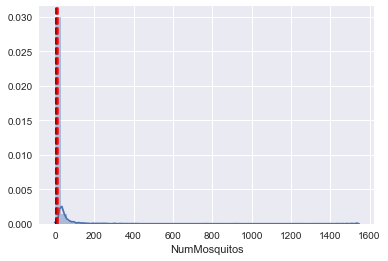

In [570]:
#plotting number of mosquitos in traps without WNV (black is median, red is mean)
no_wnv = sns.distplot(train[train["WnvPresent"]==0].NumMosquitos)
no_wnv.axvline(train[train["WnvPresent"]==0].NumMosquitos.median(), lw=2.5, ls='dashed', color='black')
no_wnv.axvline(train[train["WnvPresent"]==0].NumMosquitos.mean(), lw=2.5, ls='dashed', color='red')

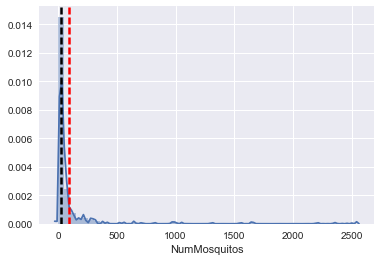

In [571]:
#plotting number of mosquitos in traps with WNV (black is median, red is mean)
wnv = sns.distplot(train[train["WnvPresent"]==1].NumMosquitos)
wnv.axvline(train[train["WnvPresent"]==1].NumMosquitos.median(), lw=2.5, ls='dashed', color='black')
wnv.axvline(train[train["WnvPresent"]==1].NumMosquitos.mean(), lw=2.5, ls='dashed', color='red')

In [572]:
#Which species of mosquitos most typically carried WNV?
#counting number of traps in which WNV is present vs. absent by species
species_groups = train.groupby(["Species", "WnvPresent"]).WnvPresent.count().unstack()

#filling NaN values for species where WNV was never present
species_groups[1].fillna(value=0.0, inplace=True) 

#calculating total traps counted for each species
species_groups["Total"] = species_groups[0] + species_groups[1]

#calculating proportion of all traps for each species in which WNV was present
species_groups["Trap_WNV_Prob"] = (species_groups[1]/species_groups["Total"])

species_groups

#only CULEX PIPIENS, CULEX PIPIENS/RESTUANS, CULEX RESTUANS were found to carry WNV. 
# 9.4% of traps containing CULEX PIPIENS contained WNV; 
# 5.9% of traps containing CULEX PIPIENS/RESTUANS contained WNV; 
# 2.0% of traps containing CULEX RESTUANS contained WNV; 

WnvPresent,0.0,1.0,Total,Trap_WNV_Prob
Species,,,,
CULEX ERRATICUS,1.0,0.0,1.0,0.000000
CULEX PIPIENS,1766.0,184.0,1950.0,0.094359
CULEX PIPIENS/RESTUANS,3601.0,225.0,3826.0,0.058808
CULEX RESTUANS,2345.0,48.0,2393.0,0.020059
CULEX SALINARIUS,83.0,0.0,83.0,0.000000
CULEX TARSALIS,6.0,0.0,6.0,0.000000
CULEX TERRITANS,216.0,0.0,216.0,0.000000


In [573]:
#defining function to check trap statistics for each year in train set (datasets already created above)

def trap_wnv_proportion(train_year):
    trap_groups = train_year.groupby(["Trap","WnvPresent"]).WnvPresent.count().unstack()
    #filling NaN values for species where WNV was never present
    trap_groups[1].fillna(value=0.0, inplace=True) 
    #calculating total traps counted for each species
    trap_groups["Total"] = trap_groups[0] + trap_groups[1]
    #calculating proportion of all traps for each species in which WNV was present
    trap_groups["Trap_WNV_Prob"] = (trap_groups[1]/trap_groups["Total"])
    print"Number of traps recorded in timeframe: ", len(trap_groups)
    print
    print"Number of traps with some wnv detected: ",trap_groups[trap_groups["Trap_WNV_Prob"] > 0.0].shape[0]
    print
    print"Number of traps with no wnv detected: ",trap_groups[trap_groups["Trap_WNV_Prob"] == 0.0].shape[0]
    print
    print"Proportion of total traps with wnv detected at some point during timeframe: ", float(trap_groups[trap_groups["Trap_WNV_Prob"] > 0.0].shape[0])/len(trap_groups) 
    print
    print"Traps sorted by proportion of times wnv was detected when checked"
    print
    return trap_groups.sort_values(by="Trap_WNV_Prob", ascending=False)



In [574]:
#Examining wnv stats by trap in 2007
trap_wnv_proportion(train_2007)

Number of traps recorded in timeframe:  116

Number of traps with some wnv detected:  69

Number of traps with no wnv detected:  47

Proportion of total traps with wnv detected at some point during timeframe:  0.594827586207

Traps sorted by proportion of times wnv was detected when checked



WnvPresent,0.0,1.0,Total,Trap_WNV_Prob
Trap,,,,
T115,23.0,12.0,35.0,0.342857
T082,16.0,6.0,22.0,0.272727
T011,25.0,7.0,32.0,0.218750
T221,13.0,3.0,16.0,0.187500
T138,39.0,9.0,48.0,0.187500
T135,32.0,7.0,39.0,0.179487
T128,23.0,5.0,28.0,0.178571
T143,23.0,5.0,28.0,0.178571
T016,25.0,5.0,30.0,0.166667


In [575]:
#Examining wnv stats by trap in 2009
trap_wnv_proportion(train_2009)

Number of traps recorded in timeframe:  73

Number of traps with some wnv detected:  16

Number of traps with no wnv detected:  57

Proportion of total traps with wnv detected at some point during timeframe:  0.219178082192

Traps sorted by proportion of times wnv was detected when checked



WnvPresent,0.0,1.0,Total,Trap_WNV_Prob
Trap,,,,
T230,9.0,1.0,10.0,0.100000
T228,10.0,1.0,11.0,0.090909
T095,27.0,2.0,29.0,0.068966
T013,14.0,1.0,15.0,0.066667
T903,37.0,2.0,39.0,0.051282
T009,24.0,1.0,25.0,0.040000
T221,25.0,1.0,26.0,0.038462
T900,56.0,2.0,58.0,0.034483
T225,30.0,1.0,31.0,0.032258


In [576]:
#Examining wnv stats by trap in 2011
trap_wnv_proportion(train_2011)

Number of traps recorded in timeframe:  80

Number of traps with some wnv detected:  23

Number of traps with no wnv detected:  57

Proportion of total traps with wnv detected at some point during timeframe:  0.2875

Traps sorted by proportion of times wnv was detected when checked



WnvPresent,0.0,1.0,Total,Trap_WNV_Prob
Trap,,,,
T900,41.0,12.0,53.0,0.226415
T223,22.0,5.0,27.0,0.185185
T903,33.0,7.0,40.0,0.175000
T003,30.0,3.0,33.0,0.090909
T218,20.0,2.0,22.0,0.090909
T081,10.0,1.0,11.0,0.090909
T225,22.0,2.0,24.0,0.083333
T158,13.0,1.0,14.0,0.071429
T028,15.0,1.0,16.0,0.062500


In [577]:
#Examining wnv stats by trap in 2013
trap_wnv_proportion(train_2013)

Number of traps recorded in timeframe:  74

Number of traps with some wnv detected:  59

Number of traps with no wnv detected:  15

Proportion of total traps with wnv detected at some point during timeframe:  0.797297297297

Traps sorted by proportion of times wnv was detected when checked



WnvPresent,0.0,1.0,Total,Trap_WNV_Prob
Trap,,,,
T900,28.0,15.0,43.0,0.348837
T225,21.0,8.0,29.0,0.275862
T013,21.0,8.0,29.0,0.275862
T003,19.0,7.0,26.0,0.269231
T235,23.0,7.0,30.0,0.233333
T030,24.0,7.0,31.0,0.225806
T233,24.0,6.0,30.0,0.200000
T027,24.0,6.0,30.0,0.200000
T028,24.0,6.0,30.0,0.200000


In [578]:
#Examining wnv stats by trap for all train years 
#creating dataframe to merge proportions onto train at later point
trap_proportion = trap_wnv_proportion(train)

#resetting index to allow for 
trap_proportion.reset_index(inplace=True)
trap_proportion.head()
#across all train years, 39 traps never had wnv detected.  This could be an important criteria for analysis.

Number of traps recorded in timeframe:  136

Number of traps with some wnv detected:  97

Number of traps with no wnv detected:  39

Proportion of total traps with wnv detected at some point during timeframe:  0.713235294118

Traps sorted by proportion of times wnv was detected when checked



WnvPresent,Trap,0.0,1.0,Total,Trap_WNV_Prob
0,T900,125.0,29.0,154.0,0.188312
1,T143,23.0,5.0,28.0,0.178571
2,T006,20.0,4.0,24.0,0.166667
3,T086,36.0,7.0,43.0,0.162791
4,T014,24.0,4.0,28.0,0.142857


In [579]:
#Which traps never had WNV?  
no_wnv_traps = trap_wnv_proportion(train)
#Separating out traps with no detected WNV in any of the train years
no_wnv_traps = no_wnv_traps[no_wnv_traps["Trap_WNV_Prob"] == 0.0]
#saving list of traps with no detected wnv into separate list for future use.
no_wnv_traps = sorted(list(no_wnv_traps.index.values))

print "List of traps with no detected WNV in any of the train years: " 
print no_wnv_traps
#There are 39 traps that never had wnv detected in the four years of train data.

Number of traps recorded in timeframe:  136

Number of traps with some wnv detected:  97

Number of traps with no wnv detected:  39

Proportion of total traps with wnv detected at some point during timeframe:  0.713235294118

Traps sorted by proportion of times wnv was detected when checked

List of traps with no detected WNV in any of the train years: 
['T001', 'T004', 'T007', 'T017', 'T018', 'T019', 'T025', 'T034', 'T040', 'T043', 'T044', 'T046', 'T050', 'T051', 'T060', 'T071', 'T072', 'T075', 'T076', 'T078', 'T088', 'T092', 'T094B', 'T099', 'T100', 'T129', 'T141', 'T146', 'T148', 'T149', 'T150', 'T153', 'T157', 'T161', 'T206', 'T219', 'T229', 'T237', 'T238']


In [580]:
# #Which traps ever had WNV? 
ever_wnv_traps = trap_wnv_proportion(train)
#Separating out traps with detected WNV in any of the train years
ever_wnv_traps = ever_wnv_traps[ever_wnv_traps["Trap_WNV_Prob"] > 0.0]
#saving list of traps with detected wnv into separate list for future use.
ever_wnv_traps = sorted(list(ever_wnv_traps.index.values))

print "List of traps with any detected WNV in any of the train years: " 
print ever_wnv_traps
print(len(ever_wnv_traps))

#There are a total of 97 traps that ever had wnv detected in the four years of train data.

Number of traps recorded in timeframe:  136

Number of traps with some wnv detected:  97

Number of traps with no wnv detected:  39

Proportion of total traps with wnv detected at some point during timeframe:  0.713235294118

Traps sorted by proportion of times wnv was detected when checked

List of traps with any detected WNV in any of the train years: 
['T002', 'T003', 'T005', 'T006', 'T008', 'T009', 'T011', 'T012', 'T013', 'T014', 'T015', 'T016', 'T027', 'T028', 'T030', 'T031', 'T033', 'T035', 'T036', 'T037', 'T039', 'T045', 'T047', 'T048', 'T049', 'T054', 'T054C', 'T061', 'T062', 'T063', 'T065', 'T066', 'T067', 'T069', 'T070', 'T073', 'T074', 'T077', 'T079', 'T080', 'T081', 'T082', 'T083', 'T084', 'T085', 'T086', 'T089', 'T090', 'T091', 'T094', 'T095', 'T096', 'T097', 'T102', 'T103', 'T107', 'T114', 'T115', 'T128', 'T135', 'T138', 'T142', 'T143', 'T144', 'T145', 'T147', 'T151', 'T152', 'T154', 'T155', 'T156', 'T158', 'T159', 'T160', 'T162', 'T200', 'T209', 'T212', 'T215', 'T218', '

In [581]:
#Which traps had WNV more than once per year? 
def two_plus_wnv_per_year(train_year):
    wnv_traps = trap_wnv_proportion(train_year)
    #Separating out traps with no detected WNV in any of the train years
    wnv_traps = wnv_traps[wnv_traps[1] > 2.0]
    #returning list of traps with no detected wnv into separate list for future use.
    return sorted(list(wnv_traps.index.values))

In [582]:
#Finding traps that had at least two instances of WNV in any of the train years, and creating an unduplicated list
#sorry for all of the extra output from the wnv_per_year functions
multi_wnv_2007 = two_plus_wnv_per_year(train_2007)
multi_wnv_2009 = two_plus_wnv_per_year(train_2009)
multi_wnv_2011 = two_plus_wnv_per_year(train_2011)
multi_wnv_2013 = two_plus_wnv_per_year(train_2013)

multi_wvn_all = []

for i in multi_wnv_2007:
    multi_wvn_all.append(i)
    
for i in multi_wnv_2009:
    multi_wvn_all.append(i)

for i in multi_wnv_2011:
    multi_wvn_all.append(i)

for i in multi_wnv_2013:
    multi_wvn_all.append(i)

print(len(multi_wvn_all))
    
multi_wvn_all = set(multi_wvn_all)

print(len(multi_wvn_all))

multi_wvn_all

#There are 52 traps that had wnv detected at least twice in any year of the train data.
#compare this list to ever_wnv_traps to see if there are any differences.

Number of traps recorded in timeframe:  116

Number of traps with some wnv detected:  69

Number of traps with no wnv detected:  47

Proportion of total traps with wnv detected at some point during timeframe:  0.594827586207

Traps sorted by proportion of times wnv was detected when checked

Number of traps recorded in timeframe:  73

Number of traps with some wnv detected:  16

Number of traps with no wnv detected:  57

Proportion of total traps with wnv detected at some point during timeframe:  0.219178082192

Traps sorted by proportion of times wnv was detected when checked

Number of traps recorded in timeframe:  80

Number of traps with some wnv detected:  23

Number of traps with no wnv detected:  57

Proportion of total traps with wnv detected at some point during timeframe:  0.2875

Traps sorted by proportion of times wnv was detected when checked

Number of traps recorded in timeframe:  74

Number of traps with some wnv detected:  59

Number of traps with no wnv detected:  15


{'T002',
 'T003',
 'T006',
 'T008',
 'T009',
 'T011',
 'T013',
 'T014',
 'T015',
 'T016',
 'T027',
 'T028',
 'T030',
 'T031',
 'T033',
 'T045',
 'T047',
 'T054',
 'T061',
 'T066',
 'T082',
 'T086',
 'T089',
 'T090',
 'T094',
 'T096',
 'T103',
 'T114',
 'T115',
 'T128',
 'T135',
 'T138',
 'T143',
 'T147',
 'T151',
 'T155',
 'T160',
 'T209',
 'T212',
 'T215',
 'T221',
 'T223',
 'T225',
 'T226',
 'T227',
 'T228',
 'T230',
 'T231',
 'T233',
 'T235',
 'T900',
 'T903'}

In [583]:
# #Which traps had WNV more than one year / every year?
#adjusting formula to examine all traps, regardless of WNV detection.

def one_ormore_wnv_per_year(train_year):
    wnv_traps = trap_wnv_proportion(train_year)
    #Separating out traps with at least one detected WNV in the train year
    wnv_traps = wnv_traps[wnv_traps[1] >= 0.0]
    #wnv_traps = wnv_traps[wnv_traps[1] >= 1.0]
    #returning list of traps with at least one detected wnv into separate list for future use.
    return wnv_traps[1]

In [584]:
# #Which traps had WNV more than one year / every year?
one_ormore_wnv_2007 = one_ormore_wnv_per_year(train_2007)
one_ormore_wnv_2009 = one_ormore_wnv_per_year(train_2009)
one_ormore_wnv_2011 = one_ormore_wnv_per_year(train_2011)
one_ormore_wnv_2013 = one_ormore_wnv_per_year(train_2013)

#one_ormore_wnv_2007
#concatenating yearly traps into single dataframe
one_ormore_all = pd.concat([one_ormore_wnv_2007, one_ormore_wnv_2009, one_ormore_wnv_2011, one_ormore_wnv_2013], axis=1)

one_ormore_all.fillna(0, inplace=True)
one_ormore_all.columns = ["2007 WNV Detections", "2009 WNV Detections", "2011 WNV Detections", "2013 WNV Detections"]

one_ormore_all["Num_Years_Trap_WNV_Detection"] = (one_ormore_all != 0).sum(axis=1)
one_ormore_all["Max_One_Year_Trap_WNV_Detections"] = one_ormore_all[["2007 WNV Detections",
                                                                    "2009 WNV Detections",
                                                                    "2011 WNV Detections",
                                                                    "2013 WNV Detections"]].max(axis=1)
one_ormore_all["Total_Train_Trap_WNV_Detections"] = one_ormore_all[["2007 WNV Detections",
                                                                    "2009 WNV Detections",
                                                                    "2011 WNV Detections",
                                                                    "2013 WNV Detections"]].sum(axis=1)


#resetting index to allow later merging more easily.
one_ormore_all.reset_index(inplace=True)
#one_ormore_all.rename(columns={'index':'Trap'}, inplace=True)
one_ormore_all

Number of traps recorded in timeframe:  116

Number of traps with some wnv detected:  69

Number of traps with no wnv detected:  47

Proportion of total traps with wnv detected at some point during timeframe:  0.594827586207

Traps sorted by proportion of times wnv was detected when checked

Number of traps recorded in timeframe:  73

Number of traps with some wnv detected:  16

Number of traps with no wnv detected:  57

Proportion of total traps with wnv detected at some point during timeframe:  0.219178082192

Traps sorted by proportion of times wnv was detected when checked

Number of traps recorded in timeframe:  80

Number of traps with some wnv detected:  23

Number of traps with no wnv detected:  57

Proportion of total traps with wnv detected at some point during timeframe:  0.2875

Traps sorted by proportion of times wnv was detected when checked

Number of traps recorded in timeframe:  74

Number of traps with some wnv detected:  59

Number of traps with no wnv detected:  15


,index,2007 WNV Detections,2009 WNV Detections,2011 WNV Detections,2013 WNV Detections,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections
0,T001,0.0,0.0,0.0,0.0,0,0.0,0.0
1,T002,7.0,1.0,1.0,6.0,4,7.0,15.0
2,T003,4.0,0.0,3.0,7.0,3,7.0,14.0
3,T004,0.0,0.0,0.0,0.0,0,0.0,0.0
4,T005,2.0,0.0,0.0,0.0,1,2.0,2.0
5,T006,4.0,0.0,0.0,0.0,1,4.0,4.0
6,T007,0.0,0.0,0.0,0.0,0,0.0,0.0
7,T008,4.0,0.0,1.0,4.0,3,4.0,9.0
8,T009,3.0,1.0,0.0,4.0,3,4.0,8.0
9,T011,7.0,1.0,0.0,3.0,3,7.0,11.0


In [585]:
#separate out list of traps with at least 2 years detections
two_plus_year_wnv_traps = one_ormore_all[one_ormore_all["Num_Years_Trap_WNV_Detection"]>=2]
two_plus_year_wnv_traps = sorted(list(two_plus_year_wnv_traps.index.values))
print(len(two_plus_year_wnv_traps))

#separate out list of traps with 4 years detection
three_year_wnv_traps = one_ormore_all[one_ormore_all["Num_Years_Trap_WNV_Detection"]==3]
three_year_wnv_traps = sorted(list(three_year_wnv_traps.index.values))
print(len(three_year_wnv_traps))


#There were 25 traps in which WNV was found at least two of the train years
#There were 3 traps in which WNV was found at three of the train years
#There were no traps in which WNV was detected in all years of the train data

#Add a column to the train data specifying the number of years in which WNV was detected (from one_ormore_all)?

46
16


In [586]:
# #How consistent were satellite traps with their parent traps in detecting WNV?

In [587]:
#create weighted proportion column for mosquito species - one for each of the three known carriers 
    #(CULEX PIPIENS, CULEX PIPIENS/RESTUANS, and CULEX RESTUANS) and one for all others == 0.0
train["Mos_WNV_Prob"] = 0.0
train.ix[train.Species == "CULEX PIPIENS/RESTUANS", "Mos_WNV_Prob"] = 0.058808
train.ix[train.Species == "CULEX PIPIENS", "Mos_WNV_Prob"] = 0.094359
train.ix[train.Species == "CULEX RESTUANS", "Mos_WNV_Prob"] = 0.020059
#train.ix[train.Mos_WNV_Prob == "", "Mos_WNV_Prob"] = 0.0

# create series of feature columns for traps:
    # Traps never containing wnv
train["Trap_Ever_Wnv"] = 0.0
train.ix[train.Trap.isin(ever_wnv_traps), "Trap_Ever_Wnv"] = 1.0
#train.ix[train.Ever_Wnv == "", "Trap_Ever_Wnv"] = 0.0



In [588]:
train.shape

(8475, 12)

In [589]:
# Number of training years in which WNV was detected in Trap
# Maximum times Trap contained WNV in one year
# Total times Trap contained WNV across all training years

train = pd.merge(train, one_ormore_all[["index","Num_Years_Trap_WNV_Detection", "Max_One_Year_Trap_WNV_Detections", 
                                       "Total_Train_Trap_WNV_Detections"]], left_on='Trap', right_on='index')
train.drop("index", axis=1, inplace=True)

#Merging in Trap_WNV_Prob
train = pd.merge(train, trap_proportion[["Trap","Trap_WNV_Prob"]], left_on='Trap', right_on='Trap')

train = train.sort_values(by=['Date', "Trap", "Species"])
train.reset_index(inplace=True, drop=True)
train.head()


,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite,Mos_WNV_Prob,Trap_Ever_Wnv,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0,0.058808,1.0,4,7.0,15.0,0.102041
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1.0,0.0,2007.0,T002,0.0,0.020059,1.0,4,7.0,15.0,0.102041
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1.0,0.0,2007.0,T007,0.0,0.020059,0.0,0,0.0,0.0,0.000000
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1.0,0.0,2007.0,T015,0.0,0.058808,1.0,1,4.0,4.0,0.125000
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4.0,0.0,2007.0,T015,0.0,0.020059,1.0,1,4.0,4.0,0.125000


In [591]:
train.Num_Years_Trap_WNV_Detection.value_counts()# Proporton of times checked that trap had WNV present

1    2742
2    2465
3    1805
0     972
4     491
Name: Num_Years_Trap_WNV_Detection, dtype: int64

In [73]:
train.Species.value_counts()

CULEX PIPIENS/RESTUANS    3826
CULEX RESTUANS            2393
CULEX PIPIENS             1950
CULEX TERRITANS            216
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [74]:
#creating rolling averages of number of mosquitos by species
#create separate dfs grouping by date and species, and summing NumMosquitos
#create new columns "NumMos_3ob_avg" which, is an average of the total number of mosquitos of that species within the
#last three observation dates.

#after creating each df, merge dfs back onto train, merging by date and species.
#I'd love to have done this by trap, but it would be significantly more complex

#I appreciate that this poses problems when calculating the averages of the first few observations in each year.
#This is a somewhat rough measure, but hopefully this error will be offset by the other variables to a large extent.

PIPIENS_RESTUANS = train[train["Species"] == "CULEX PIPIENS/RESTUANS"].groupby(["Date", "Species"]).NumMosquitos.sum()
PIPIENS_RESTUANS = pd.DataFrame(PIPIENS_RESTUANS)
PIPIENS_RESTUANS.reset_index(inplace=True, drop=False)

#creating average of last three observation sums, where three prior obs aren't available, 
#take either 1 or 2 obs (e.g. use of min_periods)
PIPIENS_RESTUANS["NumMos_3ob_avg"] = PIPIENS_RESTUANS["NumMosquitos"].rolling(window=3, min_periods=1,center=False).mean()

PIPIENS_RESTUANS.head()

,Date,Species,NumMosquitos,NumMos_3ob_avg
0,2007-05-29,CULEX PIPIENS/RESTUANS,10.0,10.000000
1,2007-06-05,CULEX PIPIENS/RESTUANS,28.0,19.000000
2,2007-06-26,CULEX PIPIENS/RESTUANS,69.0,35.666667
3,2007-06-29,CULEX PIPIENS/RESTUANS,24.0,40.333333
4,2007-07-02,CULEX PIPIENS/RESTUANS,132.0,75.000000


In [75]:
RESTUANS = train[train["Species"] == "CULEX RESTUANS"].groupby(["Date", "Species"]).NumMosquitos.sum()
RESTUANS = pd.DataFrame(RESTUANS)
RESTUANS.reset_index(inplace=True, drop=False)

#creating average of last three observation sums, where three prior obs aren't available, 
#take either 1 or 2 obs (e.g. use of min_periods)
RESTUANS["NumMos_3ob_avg"] = RESTUANS["NumMosquitos"].rolling(window=3, min_periods=1,center=False).mean()

RESTUANS.head()

,Date,Species,NumMosquitos,NumMos_3ob_avg
0,2007-05-29,CULEX RESTUANS,29.0,29.000000
1,2007-06-05,CULEX RESTUANS,93.0,61.000000
2,2007-06-26,CULEX RESTUANS,138.0,86.666667
3,2007-06-29,CULEX RESTUANS,55.0,95.333333
4,2007-07-02,CULEX RESTUANS,100.0,97.666667


In [76]:
PIPIENS = train[train["Species"] == "CULEX PIPIENS"].groupby(["Date", "Species"]).NumMosquitos.sum()
PIPIENS = pd.DataFrame(PIPIENS)
PIPIENS.reset_index(inplace=True, drop=False)

#creating average of last three observation sums, where three prior obs aren't available, 
#take either 1 or 2 obs (e.g. use of min_periods)
PIPIENS["NumMos_3ob_avg"] = PIPIENS["NumMosquitos"].rolling(window=3, min_periods=1,center=False).mean()

PIPIENS.head()

,Date,Species,NumMosquitos,NumMos_3ob_avg
0,2007-05-29,CULEX PIPIENS,1.0,1.000000
1,2007-06-05,CULEX PIPIENS,6.0,3.500000
2,2007-06-26,CULEX PIPIENS,8.0,5.000000
3,2007-06-29,CULEX PIPIENS,6.0,6.666667
4,2007-07-02,CULEX PIPIENS,4.0,6.000000


In [77]:
TERRITANS = train[train["Species"] == "CULEX TERRITANS"].groupby(["Date", "Species"]).NumMosquitos.sum()
TERRITANS = pd.DataFrame(TERRITANS)
TERRITANS.reset_index(inplace=True, drop=False)

#creating average of last three observation sums, where three prior obs aren't available, 
#take either 1 or 2 obs (e.g. use of min_periods)
TERRITANS["NumMos_3ob_avg"] = TERRITANS["NumMosquitos"].rolling(window=3, min_periods=1,center=False).mean()

TERRITANS.head()

,Date,Species,NumMosquitos,NumMos_3ob_avg
0,2007-07-11,CULEX TERRITANS,3.0,3.000000
1,2007-07-18,CULEX TERRITANS,3.0,3.000000
2,2007-07-19,CULEX TERRITANS,6.0,4.000000
3,2007-07-25,CULEX TERRITANS,1.0,3.333333
4,2007-08-01,CULEX TERRITANS,16.0,7.666667


In [78]:
SALINARIUS = train[train["Species"] == "CULEX SALINARIUS"].groupby(["Date", "Species"]).NumMosquitos.sum()
SALINARIUS = pd.DataFrame(SALINARIUS)
SALINARIUS.reset_index(inplace=True, drop=False)

#creating average of last three observation sums, where three prior obs aren't available, 
#take either 1 or 2 obs (e.g. use of min_periods)
SALINARIUS["NumMos_3ob_avg"] = SALINARIUS["NumMosquitos"].rolling(window=3, min_periods=1,center=False).mean()

SALINARIUS.head()

,Date,Species,NumMosquitos,NumMos_3ob_avg
0,2007-06-26,CULEX SALINARIUS,1.0,1.0
1,2007-07-02,CULEX SALINARIUS,4.0,2.5
2,2007-07-11,CULEX SALINARIUS,4.0,3.0
3,2007-07-18,CULEX SALINARIUS,4.0,4.0
4,2007-07-19,CULEX SALINARIUS,1.0,3.0


In [79]:
TARSALIS = train[train["Species"] == "CULEX TARSALIS"].groupby(["Date", "Species"]).NumMosquitos.sum()
TARSALIS = pd.DataFrame(TARSALIS)
TARSALIS.reset_index(inplace=True, drop=False)

#creating average of last three observation sums, where three prior obs aren't available, 
#take either 1 or 2 obs (e.g. use of min_periods)
TARSALIS["NumMos_3ob_avg"] = TARSALIS["NumMosquitos"].rolling(window=3, min_periods=1,center=False).mean()

TARSALIS.head()

,Date,Species,NumMosquitos,NumMos_3ob_avg
0,2009-08-25,CULEX TARSALIS,1.0,1.000000
1,2009-09-25,CULEX TARSALIS,1.0,1.000000
2,2011-09-16,CULEX TARSALIS,5.0,2.333333


In [80]:
ERRATICUS = train[train["Species"] == "CULEX ERRATICUS"].groupby(["Date", "Species"]).NumMosquitos.sum()
ERRATICUS = pd.DataFrame(ERRATICUS)
ERRATICUS.reset_index(inplace=True, drop=False)

#creating average of last three observation sums, where three prior obs aren't available, 
#take either 1 or 2 obs (e.g. use of min_periods)
ERRATICUS["NumMos_3ob_avg"] = ERRATICUS["NumMosquitos"].rolling(window=3, min_periods=1,center=False).mean()

ERRATICUS.head()

,Date,Species,NumMosquitos,NumMos_3ob_avg
0,2013-09-06,CULEX ERRATICUS,7.0,7.0


In [81]:
#concatenating all mos-specific dfs on 0-axis, and merging new column onto train set.
all_mos = pd.concat([PIPIENS_RESTUANS, RESTUANS, PIPIENS, TERRITANS, SALINARIUS, TARSALIS, ERRATICUS], axis=0)

train = pd.merge(train, all_mos[["Date", "Species", "NumMos_3ob_avg"]], 
                 left_on=["Date","Species"], right_on=["Date","Species"])


In [82]:
#create a variable that examines probabilty of WNV by trap and by species

trap_mos_groups = train[["Trap","Species","WnvPresent"]].groupby(["Trap","Species","WnvPresent"]).WnvPresent.count().unstack()
#filling NaN values for instances where WNV was never present
trap_mos_groups[1].fillna(value=0.0, inplace=True) 
#calculating total WNV instances counted for each species in each trap
trap_mos_groups["Total"] = trap_mos_groups[0] + trap_mos_groups[1]
#calculating proportion of all traps for each species in which WNV was present
trap_mos_groups["Trap_Species_WNV_Prob"] = (trap_mos_groups[1]/trap_mos_groups["Total"])
trap_mos_groups = trap_mos_groups.sort_values(by="Trap_Species_WNV_Prob", ascending=False)

trap_mos_groups.reset_index(inplace=True)

trap_mos_groups = pd.DataFrame(trap_mos_groups)

In [83]:
#merging Trap_Species_WNV_Prob from trap_mos_groups into train df
train = pd.merge(train, trap_mos_groups[['Trap', "Species", "Trap_Species_WNV_Prob"]], how= "inner", left_on=['Trap', "Species"], 
                 right_on=['Trap', "Species"])


In [246]:
train.shape

(8475, 18)

In [245]:
#saving new cleaned train set to assets folder
train.to_csv("../assets/clean_train.csv")

#### Brief Weather EDA

In [37]:
#reading in cleaned weather data
weather = pd.read_csv("../assets/clean_weather.csv", index_col=0)
weather.reset_index(inplace=True, drop=True)

In [38]:
weather.head()
#it looks like there are still "T" values under precipitation. Looking at NOAA, it appears trace amounts of precipitation
#means less than .01.  Rather than convert them to 0.0, I'll inpute them as 0.001, to have something there rather than
#nothing

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448,1849,0.00,29.10,29.82,1.7,27,9.2
1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447,1850,0.00,29.38,30.09,13.0,4,13.4
2,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446,1851,0.00,29.39,30.12,11.7,7,11.9
3,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,444,1852,T,29.31,30.05,10.4,8,10.8
4,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,443,1853,T,29.40,30.10,11.7,7,12.0


In [39]:
#isolating the exact entry value of Ts in PrecipTotal
weather.loc[3, "PrecipTotal"] 
#aha, a bunch of whitespace, which illustrates why it was difficult to impute the values earlier.

'  T'

In [40]:
#inputting "T" values to .001 t looks like NOAA considers any precipitation less than .01 to be "Trace", 
# so to be conservative, I was going to impute T values as .001, so that it's still greater than 0.0. 
weather.ix[weather["PrecipTotal"] == "  T", "PrecipTotal"] = 0.001

#Converting PrecipTotal to float
weather.PrecipTotal = weather.PrecipTotal.astype('float')

#Converting Date to Datetime
weather["Date"] = pd.to_datetime(weather["Date"], infer_datetime_format=True)


In [251]:
#Adding a column to generate 7-day average of PrecipTotal
weather["Precip_7d_avg"] = weather["PrecipTotal"].rolling(window=7, min_periods=1, center=False).mean()

#creating a column that indicates if average windspeed was greater than 1 std above the mean
air_speed_thresh = weather.AvgSpeed.mean() + weather.AvgSpeed.std()

weather["wind_abv_1std"] = 0.0
weather.ix[weather["AvgSpeed"] > air_speed_thresh, "wind_abv_1std"] = 1.0

weather.head(20)

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Precip_7d_avg,wind_abv_1std
0,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448,1849,0.000,29.10,29.82,1.7,27,9.2,0.000000,0.0
1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447,1850,0.000,29.38,30.09,13.0,4,13.4,0.000000,1.0
2,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446,1851,0.000,29.39,30.12,11.7,7,11.9,0.000000,1.0
3,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,444,1852,0.001,29.31,30.05,10.4,8,10.8,0.000250,0.0
4,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,443,1853,0.001,29.40,30.10,11.7,7,12.0,0.000400,1.0
5,2007-05-06,68,49,59.0,4.0,30,46.0,6.0,0.0,442,1855,0.000,29.57,30.29,14.4,11,15.0,0.000333,1.0
6,2007-05-07,83,47,65.0,10.0,41,54.0,0.0,0.0,441,1856,0.001,29.38,30.12,8.6,18,10.5,0.000429,0.0
7,2007-05-08,82,54,68.0,12.0,58,62.0,0.0,3.0,439,1857,0.000,29.29,30.03,2.7,11,5.8,0.000429,0.0
8,2007-05-09,77,61,69.0,13.0,59,63.0,0.0,4.0,438,1858,0.130,29.21,29.94,3.9,9,6.2,0.019000,0.0
9,2007-05-10,84,56,70.0,14.0,52,60.0,0.0,5.0,437,1859,0.000,29.20,29.92,0.7,17,4.1,0.019000,0.0


In [252]:
#saving cleaned weather set to assets folder
weather.to_csv("../assets/clean_weather.csv")

### Merging Train Data with Weather data to begin modeling process

In [256]:
#reading in cleaned train data
train = pd.read_csv("../assets/clean_train.csv", index_col=0)
train["Date"] = pd.to_datetime(train["Date"], infer_datetime_format=True)

In [257]:
train.head()

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,Year,Parent_Trap,Is_Satellite,Mos_WNV_Prob,Trap_Ever_Wnv,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,NumMos_3ob_avg,Trap_Species_WNV_Prob
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1.0,0.0,2007.0,T002,0.0,0.058808,1.0,4,7.0,15.0,0.102041,10.000000,0.142857
1,2007-06-05,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,3.0,0.0,2007.0,T002,0.0,0.058808,1.0,4,7.0,15.0,0.102041,19.000000,0.142857
2,2007-06-26,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,1.0,0.0,2007.0,T002,0.0,0.058808,1.0,4,7.0,15.0,0.102041,35.666667,0.142857
3,2007-06-29,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,2.0,0.0,2007.0,T002,0.0,0.058808,1.0,4,7.0,15.0,0.102041,40.333333,0.142857
4,2007-07-02,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991,3.0,0.0,2007.0,T002,0.0,0.058808,1.0,4,7.0,15.0,0.102041,75.000000,0.142857


In [258]:
#scaling train data
scaled_train = StandardScaler().fit_transform(train[["Latitude", "Longitude", "NumMosquitos", "Mos_WNV_Prob", 
                                                     "Trap_Ever_Wnv", "Num_Years_Trap_WNV_Detection", 
                                                     "Max_One_Year_Trap_WNV_Detections", "Total_Train_Trap_WNV_Detections", 
                                                     "Trap_WNV_Prob", "NumMos_3ob_avg", "Trap_Species_WNV_Prob"]])

scaled_train = pd.DataFrame(scaled_train, columns = ["Latitude", "Longitude", "NumMosquitos", "Mos_WNV_Prob", 
                                                     "Trap_Ever_Wnv", "Num_Years_Trap_WNV_Detection", 
                                                     "Max_One_Year_Trap_WNV_Detections", "Total_Train_Trap_WNV_Detections", 
                                                     "Trap_WNV_Prob", "NumMos_3ob_avg", "Trap_Species_WNV_Prob"])

#adding date values and other categories/unscaled variables into scaled dataframe
scaled_train["Date"] = train["Date"]
scaled_train["Species"] = train["Species"]
scaled_train["Trap"] = train["Trap"]
scaled_train["WnvPresent"] = train["WnvPresent"]
scaled_train["Year"] = train["Year"]
scaled_train["Parent_Trap"] = train["Parent_Trap"]
scaled_train["Is_Satellite"] = train["Is_Satellite"]

scaled_train.head()


,Latitude,Longitude,NumMosquitos,Mos_WNV_Prob,Trap_Ever_Wnv,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,NumMos_3ob_avg,Trap_Species_WNV_Prob,Date,Species,Trap,WnvPresent,Year,Parent_Trap,Is_Satellite
0,1.032541,-1.263449,-0.198905,0.17102,0.359928,2.050194,1.162658,1.998768,1.154647,-1.126237,1.395763,2007-05-29,CULEX PIPIENS/RESTUANS,T002,0.0,2007.0,T002,0.0
1,1.032541,-1.263449,-0.172266,0.17102,0.359928,2.050194,1.162658,1.998768,1.154647,-1.110581,1.395763,2007-06-05,CULEX PIPIENS/RESTUANS,T002,0.0,2007.0,T002,0.0
2,1.032541,-1.263449,-0.198905,0.17102,0.359928,2.050194,1.162658,1.998768,1.154647,-1.081589,1.395763,2007-06-26,CULEX PIPIENS/RESTUANS,T002,0.0,2007.0,T002,0.0
3,1.032541,-1.263449,-0.185585,0.17102,0.359928,2.050194,1.162658,1.998768,1.154647,-1.073471,1.395763,2007-06-29,CULEX PIPIENS/RESTUANS,T002,0.0,2007.0,T002,0.0
4,1.032541,-1.263449,-0.172266,0.17102,0.359928,2.050194,1.162658,1.998768,1.154647,-1.013169,1.395763,2007-07-02,CULEX PIPIENS/RESTUANS,T002,0.0,2007.0,T002,0.0


In [259]:
#reading in cleaned weather data
weather = pd.read_csv("../assets/clean_weather.csv", index_col=0)
weather.reset_index(inplace=True, drop=True)
weather["Date"] = pd.to_datetime(weather["Date"], infer_datetime_format=True)

In [260]:
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Precip_7d_avg,wind_abv_1std
0,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448,1849,0.000,29.10,29.82,1.7,27,9.2,0.00000,0.0
1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447,1850,0.000,29.38,30.09,13.0,4,13.4,0.00000,1.0
2,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446,1851,0.000,29.39,30.12,11.7,7,11.9,0.00000,1.0
3,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,444,1852,0.001,29.31,30.05,10.4,8,10.8,0.00025,0.0
4,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,443,1853,0.001,29.40,30.10,11.7,7,12.0,0.00040,1.0


In [261]:
#dropping Depart, Wetbulb, Heat, Cool, Sunrise, Sunset, SeaLevel, ResultSpeed from weather, as many of these columns
#seem either duplicative or unimportant for purposes of this analysis
#after conducting EDA of weather, I'm also dropping Tmax, Tmin, and ResultDir

weather.drop(["Tmax", "Tmin", "ResultDir","Depart", "WetBulb", "Heat", "Cool", "Sunrise", "Sunset", "SeaLevel", 
              "ResultSpeed"], axis=1, inplace=True)

weather.head()

,Date,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,Precip_7d_avg,wind_abv_1std
0,2007-05-01,67.0,51,0.000,29.10,9.2,0.00000,0.0
1,2007-05-02,51.0,42,0.000,29.38,13.4,0.00000,1.0
2,2007-05-03,56.0,40,0.000,29.39,11.9,0.00000,1.0
3,2007-05-04,58.0,41,0.001,29.31,10.8,0.00025,0.0
4,2007-05-05,60.0,38,0.001,29.40,12.0,0.00040,1.0


In [262]:
#scaling weather data before merging with train data, to take advantage of ALL weather data when scaling, rather than
#just observations that would appear in the train set
scaled_weather = StandardScaler().fit_transform(weather[["Tavg", "DewPoint", "PrecipTotal", "StnPressure", 
                                                                     "AvgSpeed", "Precip_7d_avg"]])

scaled_weather = pd.DataFrame(scaled_weather, columns = ["Tavg", "DewPoint", "PrecipTotal", "StnPressure", 
                                                                     "AvgSpeed", "Precip_7d_avg"])

#adding date values into scaled dataframe
scaled_weather["Date"] = weather["Date"]
scaled_weather["wind_abv_1std"] = weather["wind_abv_1std"]

scaled_weather.head()

,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,Precip_7d_avg,Date,wind_abv_1std
0,0.037433,-0.222912,-0.319916,-0.987494,0.197482,-0.755462,2007-05-01,0.0
1,-1.485236,-1.066664,-0.319916,0.806746,1.515681,-0.755462,2007-05-02,1.0
2,-1.009402,-1.254164,-0.319916,0.870826,1.044896,-0.755462,2007-05-03,1.0
3,-0.819068,-1.160414,-0.317540,0.358186,0.699653,-0.754059,2007-05-04,0.0
4,-0.628734,-1.441665,-0.317540,0.934906,1.076281,-0.753217,2007-05-05,1.0


In [263]:
#inner merging weather with train data to begin examining relationships between weather patterns and mosquito prevalence
#initially created outer merge, but generated rolling average column for precipitation above
combine = pd.merge(scaled_weather, scaled_train, how= "inner", left_on='Date', right_on='Date')
combine.drop("Year", axis=1, inplace=True)

combine

,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,Precip_7d_avg,Date,wind_abv_1std,Latitude,Longitude,...,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,NumMos_3ob_avg,Trap_Species_WNV_Prob,Species,Trap,WnvPresent,Parent_Trap,Is_Satellite
0,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,1.032541,-1.263449,...,1.162658,1.998768,1.154647,-1.126237,1.395763,CULEX PIPIENS/RESTUANS,T002,0.0,T002,0.0
1,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,1.214515,-1.546838,...,0.163922,-0.243101,1.705585,-1.126237,1.769439,CULEX PIPIENS/RESTUANS,T015,0.0,T015,0.0
2,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,0.210971,0.482575,...,-0.501901,-0.243101,-0.603421,-1.126237,-0.305108,CULEX PIPIENS/RESTUANS,T048,0.0,T048,0.0
3,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,0.700966,0.006295,...,-1.167725,-1.058326,-1.293965,-1.126237,-0.846294,CULEX PIPIENS/RESTUANS,T050,0.0,T050,0.0
4,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,0.725562,0.745953,...,0.496834,-0.039294,-0.349225,-1.126237,-0.074438,CULEX PIPIENS/RESTUANS,T054,0.0,T054,0.0
5,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,-1.466128,0.215080,...,1.162658,0.368318,2.612426,-1.126237,2.096405,CULEX PIPIENS/RESTUANS,T086,0.0,T086,0.0
6,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,0.436274,0.990130,...,-1.167725,-1.058326,-1.293965,-1.126237,-0.846294,CULEX PIPIENS/RESTUANS,T129,0.0,T129,0.0
7,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,1.449405,-1.199137,...,0.496834,-0.039294,2.991107,-1.126237,1.769439,CULEX PIPIENS/RESTUANS,T143,0.0,T143,0.0
8,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,1.621079,0.083504,...,-1.167725,-1.058326,-1.293965,-1.126237,-0.846294,CULEX PIPIENS/RESTUANS,T148,0.0,T148,0.0
9,0.703601,0.433340,-0.319916,0.870826,-0.649931,0.103875,2007-05-29,0.0,1.032541,-1.263449,...,1.162658,1.998768,1.154647,-1.093186,-0.846294,CULEX RESTUANS,T002,0.0,T002,0.0


In [264]:
combine.columns

Index([u'Tavg', u'DewPoint', u'PrecipTotal', u'StnPressure', u'AvgSpeed',
       u'Precip_7d_avg', u'Date', u'wind_abv_1std', u'Latitude', u'Longitude',
       u'NumMosquitos', u'Mos_WNV_Prob', u'Trap_Ever_Wnv',
       u'Num_Years_Trap_WNV_Detection', u'Max_One_Year_Trap_WNV_Detections',
       u'Total_Train_Trap_WNV_Detections', u'Trap_WNV_Prob', u'NumMos_3ob_avg',
       u'Trap_Species_WNV_Prob', u'Species', u'Trap', u'WnvPresent',
       u'Parent_Trap', u'Is_Satellite'],
      dtype='object')

In [265]:
#grouping WNV counts with by date, with StnPressure, avg temp, precip_total, precip_7d_avg, and AvgSpeed
wnv_outbreaks = combine[combine["WnvPresent"] == 1].groupby(["Date", "StnPressure", "Tavg", "PrecipTotal", 
                                                             "Precip_7d_avg", "AvgSpeed"]).WnvPresent.count()
wnv_outbreaks = pd.DataFrame(wnv_outbreaks)
wnv_outbreaks.reset_index(inplace=True, drop=False)
   
#grouping mosquito counts with by date, with avg temp, and precip_total    
mos_outbreaks = combine[combine["WnvPresent"] == 1].groupby(["Date", "StnPressure", "Tavg", "PrecipTotal", 
                                                             "Precip_7d_avg", "AvgSpeed"]).NumMosquitos.sum()
mos_outbreaks = pd.DataFrame(mos_outbreaks)
mos_outbreaks.reset_index(inplace=True, drop=False)
    
#merging num_mosquitos with wnv outbreaks to see how mos numbers track WNV detections
wnv_outbreaks = pd.merge(wnv_outbreaks, mos_outbreaks[["Date", "NumMosquitos"]], left_on='Date', right_on='Date')


In [266]:
#trying scaling data to see better relationships between temperature, precipitation, num_mosquitos and WNV present

#scaling all columns but date
scaled_wnv_outbreaks = StandardScaler().fit_transform(wnv_outbreaks[["StnPressure", "Tavg", "PrecipTotal", 
                                                                     "Precip_7d_avg", "AvgSpeed", "NumMosquitos", 
                                                                     "WnvPresent"]])
scaled_wnv_outbreaks = pd.DataFrame(scaled_wnv_outbreaks, columns = ["StnPressure", "Tavg", "PrecipTotal", 
                                                                     "Precip_7d_avg","AvgSpeed", "NumMosquitos", 
                                                                     "WnvPresent"])

#adding date values into scaled dataframe
scaled_wnv_outbreaks["Date"] = wnv_outbreaks["Date"]

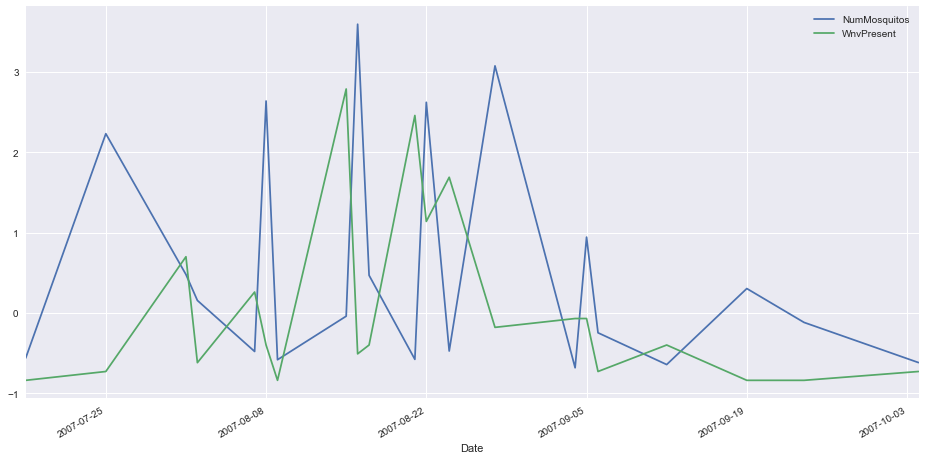

In [267]:
#looking at 2007 data
scaled_wnv_outbreaks[(scaled_wnv_outbreaks.Date > "2007-01-01") & 
                     (scaled_wnv_outbreaks.Date < "2007-12-31")].plot(x="Date", y=["NumMosquitos","WnvPresent"])

#It looks like spikes in WNV can be preceded by large outbreaks in mosquito numbers (often around a week or so before)
#though later years tend to show pretty overlapping swings in number of mosquitos and WNV presence.
#how to incorporate this into modeling, if no trap readings from exactly 7 days before?  
#Perhaps average num of mosquitos from previous seven days? 
#Would it be number of same species detected in previous seven days?
#Would we try to look at the number of mosquitos in the same trap within the last seven days? This might be best.
#Maybe 10 days to ensure that there will be some readings to average.


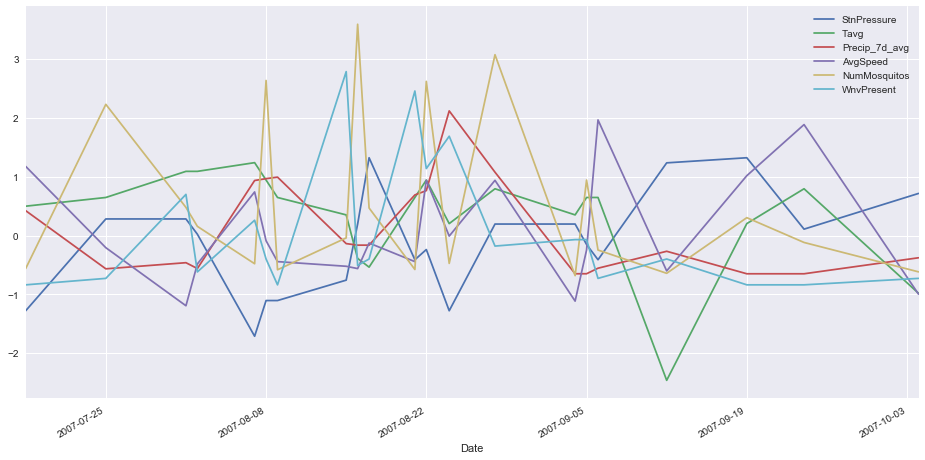

In [268]:
scaled_wnv_outbreaks[(scaled_wnv_outbreaks.Date > "2007-01-01") & 
                     (scaled_wnv_outbreaks.Date < "2007-12-31")].plot(x="Date", y=["StnPressure", "Tavg","Precip_7d_avg",
                                                                                   "AvgSpeed", "NumMosquitos", "WnvPresent"])
#number of mosquitos seems to uptick with increased average temperatures right around the same time.
#Perhaps no need to stagger temperature in predicting numbers of mosquitos?
#Maybe create an average precipitation total for last seven days?
#stronger winds (greater than 1 std over average) seems to drive down mosquito numbers?
#StnPressure seems inversely related to Wnv and NumMosquitos


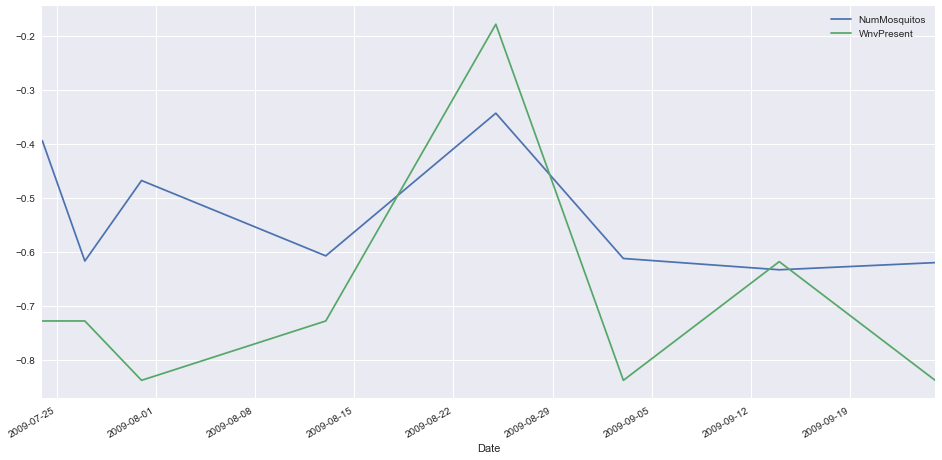

In [269]:
#looking at 2009 data

scaled_wnv_outbreaks[(scaled_wnv_outbreaks.Date > "2009-01-01") & 
                     (scaled_wnv_outbreaks.Date < "2009-12-31")].plot(x="Date", y=["NumMosquitos","WnvPresent"])


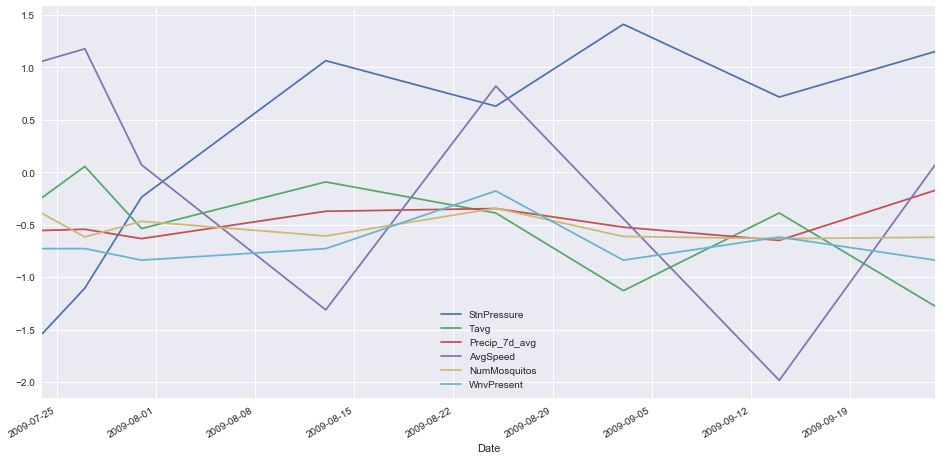

In [270]:
scaled_wnv_outbreaks[(scaled_wnv_outbreaks.Date > "2009-01-01") & 
                     (scaled_wnv_outbreaks.Date < "2009-12-31")].plot(x="Date", y=["StnPressure", "Tavg","Precip_7d_avg",
                                                                                   "AvgSpeed","NumMosquitos", "WnvPresent"])
#number of mosquitos seems to uptick with increased average temperatures right around the same time.
#Perhaps no need to stagger temperature in predicting numbers of mosquitos?
#Maybe create an average precipitation total for last seven days?
#stronger winds (greater than 1 std over average) seems to drive down mosquito numbers?


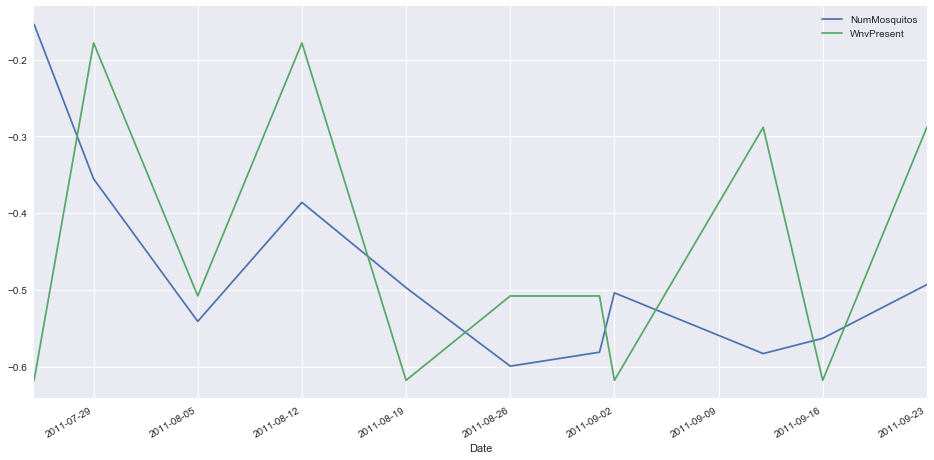

In [271]:
#looking at 2011 data

scaled_wnv_outbreaks[(scaled_wnv_outbreaks.Date > "2011-01-01") & 
                     (scaled_wnv_outbreaks.Date < "2011-12-31")].plot(x="Date", y=["NumMosquitos","WnvPresent"])

#It looks like spikes in WNV can be preceded by large outbreaks in mosquito numbers (often around a week or so before)
#how to incorporate this into modeling, if no trap readings from exactly 7 days before?  
#Perhaps average num of mosquitos from previous seven days? 
#Would it be number of same species detected in previous seven days?
#Would we try to look at the number of mosquitos in the same trap within the last seven days? 


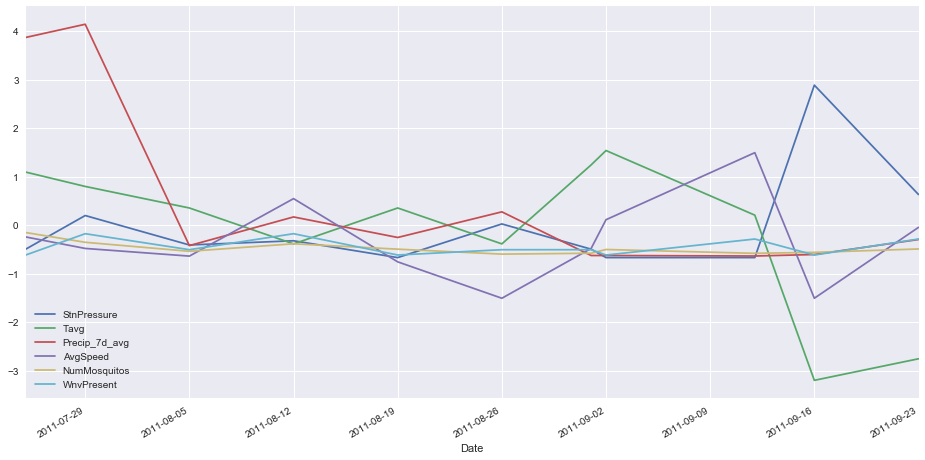

In [272]:
scaled_wnv_outbreaks[(scaled_wnv_outbreaks.Date > "2011-01-01") & 
                     (scaled_wnv_outbreaks.Date < "2011-12-31")].plot(x="Date", y=["StnPressure", "Tavg","Precip_7d_avg", 
                                                                                   "AvgSpeed","NumMosquitos", "WnvPresent"])
#number of mosquitos seems to uptick with increased average temperatures right around the same time.
#Perhaps no need to stagger temperature in predicting numbers of mosquitos?
#Maybe create an average precipitation total for last seven days?
#stronger winds (greater than 1 std over average) seems to drive down mosquito numbers?


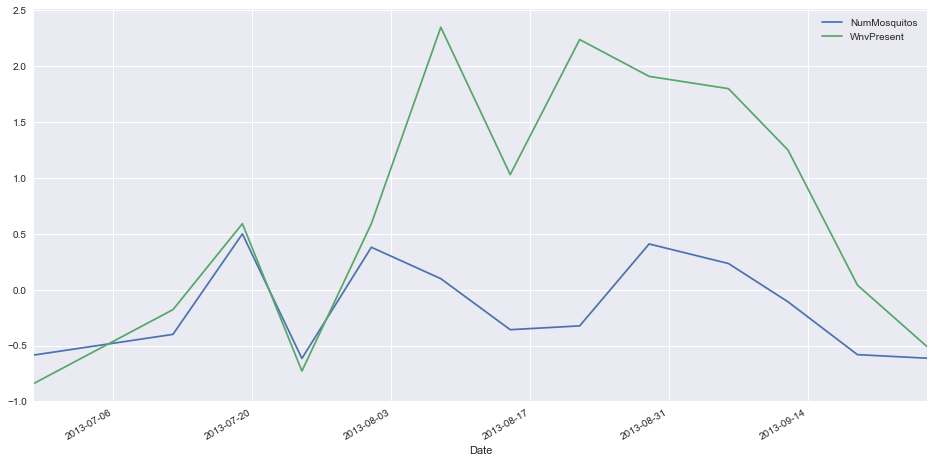

In [273]:
#looking at 2013 data

scaled_wnv_outbreaks[(scaled_wnv_outbreaks.Date > "2013-01-01") & 
                     (scaled_wnv_outbreaks.Date < "2013-12-31")].plot(x="Date", y=["NumMosquitos","WnvPresent"])

#It looks like spikes in WNV can be preceded by large outbreaks in mosquito numbers (often around a week or so before)
#how to incorporate this into modeling, if no trap readings from exactly 7 days before?  
#Perhaps average num of mosquitos from previous seven days? 
#Would it be number of same species detected in previous seven days?
#Would we try to look at the number of mosquitos in the same trap within the last seven days? 


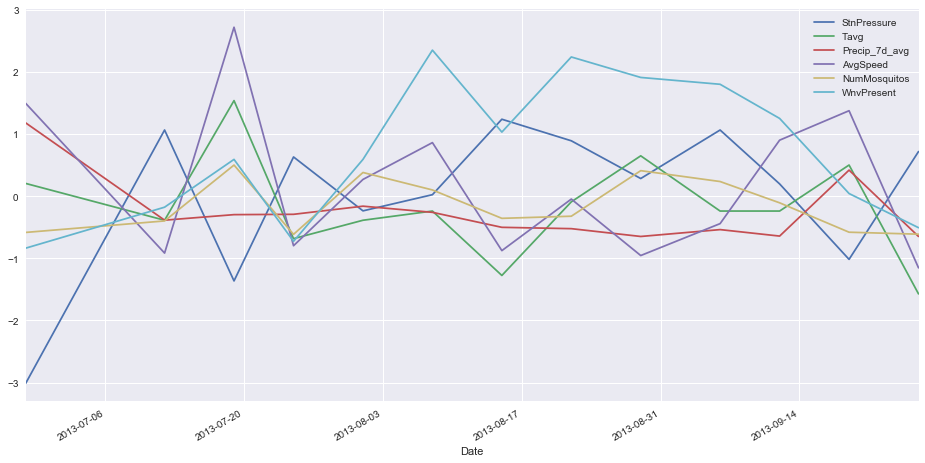

In [274]:
scaled_wnv_outbreaks[(scaled_wnv_outbreaks.Date > "2013-01-01") & 
                     (scaled_wnv_outbreaks.Date < "2013-12-31")].plot(x="Date", y=["StnPressure", "Tavg","Precip_7d_avg",
                                                                                   "AvgSpeed","NumMosquitos", "WnvPresent"])
#number of mosquitos seems to uptick with increased average temperatures right around the same time.
#Perhaps no need to stagger temperature in predicting numbers of mosquitos?
#Maybe create an average precipitation total for last seven days?
#stronger winds (greater than 1 std over average) seems to drive down mosquito numbers?


# Modeling to Predict Presence of WNV

In [221]:
combine.columns

Index([u'Tavg', u'DewPoint', u'PrecipTotal', u'StnPressure', u'AvgSpeed',
       u'Precip_7d_avg', u'Date', u'wind_abv_1std', u'Latitude', u'Longitude',
       u'NumMosquitos', u'Mos_WNV_Prob', u'Trap_Ever_Wnv',
       u'Num_Years_Trap_WNV_Detection', u'Max_One_Year_Trap_WNV_Detections',
       u'Total_Train_Trap_WNV_Detections', u'Trap_WNV_Prob', u'NumMos_3ob_avg',
       u'Trap_Species_WNV_Prob', u'Species', u'Trap', u'WnvPresent',
       u'Parent_Trap', u'Is_Satellite'],
      dtype='object')

In [231]:
#dropping "Parent_Trap", "Is_Satellite" because I don't believe these will be helpful at this point
#also dropping Date, Species, and Trap, as these are categorical variables that we're already accounting for in a 
#number of ways (including global Mos_WNV_Prob and Trap_WNV_Prob variables, among others)

X = combine.copy()

#You can add or remove variables as you like and rerun the cell to produce your desired X - you shouldn't 
#need to go back above this cell unless you want to change the variables or scaling or data that was done above.
X.drop(["Date", "Parent_Trap", "Is_Satellite", "Species", "Trap", "WnvPresent"], axis=1, inplace=True)

#preparing y values
y = combine["WnvPresent"]

In [232]:
X.head()

,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,Precip_7d_avg,wind_abv_1std,Latitude,Longitude,NumMosquitos,Mos_WNV_Prob,Trap_Ever_Wnv,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,NumMos_3ob_avg,Trap_Species_WNV_Prob
0,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,0.0,1.032541,-1.263449,-0.198905,0.17102,0.359928,2.050194,1.162658,1.998768,1.154647,-1.126237,1.395763
1,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,0.0,1.214515,-1.546838,-0.198905,0.17102,0.359928,-0.715267,0.163922,-0.243101,1.705585,-1.126237,1.769439
2,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,0.0,0.210971,0.482575,-0.198905,0.17102,0.359928,0.206553,-0.501901,-0.243101,-0.603421,-1.126237,-0.305108
3,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,0.0,0.700966,0.006295,-0.198905,0.17102,-2.778333,-1.637088,-1.167725,-1.058326,-1.293965,-1.126237,-0.846294
4,0.703601,0.43334,-0.319916,0.870826,-0.649931,0.103875,0.0,0.725562,0.745953,-0.185585,0.17102,0.359928,-0.715267,0.496834,-0.039294,-0.349225,-1.126237,-0.074438


In [233]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: WnvPresent, dtype: float64

In [234]:
#creating function to test and fit classification model (created for SVM lab)
def do_cm_cr(model, X, y, names): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    model.fit(X_train, y_train)
    y_probs = model.predict(X_test)    #predict y values for X_test
    print "Output for Tested Model:"
    print "Confusion Matrix of Predictions: "
    print
    print(confusion_matrix(y_test, y_probs)) # Actual values are rows (0, 1), while predicted are columns (0, 1); 
    print
    #printing classification report
    #precision is true positives / (true positives + false positives) - of all predicted, % correct
    #recall is true positives / (true positives + false negatives) - of all actual, % correct
    #f1-score is a weighted harmonic mean of the precision and recall, f1-score reaches best value at 1 and worst at 0.
    #support is number of true values for each class
    print "Classification Matrix: "
    print
    print(classification_report(y_test, y_probs, target_names=names))
    return model.score(X_test,y_test)

In [235]:
#we'll start with Logistic Regression
logreg = LogisticRegression()

do_cm_cr(logreg, X, y, ["no_Wnv", "yes_Wnv"])


Output for Tested Model:
Confusion Matrix of Predictions: 

[[2628   18]
 [ 136   15]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      0.99      0.97      2646
    yes_Wnv       0.45      0.10      0.16       151

avg / total       0.92      0.94      0.93      2797



0.94494100822309612

In [236]:
#k-nearest neighbors
knnc = KNeighborsClassifier()

do_cm_cr(knnc, X, y, ["no_Wnv", "yes_Wnv"])

#After scaling the X data, the knnc performs effectively as well as logistic regression


Output for Tested Model:
Confusion Matrix of Predictions: 

[[2629   17]
 [ 135   16]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      0.99      0.97      2646
    yes_Wnv       0.48      0.11      0.17       151

avg / total       0.93      0.95      0.93      2797



0.94565606006435465

In [237]:
#SVM with linear kernal
lin_svm = svm.SVC(kernel='linear')

do_cm_cr(lin_svm, X, y, ["no_Wnv", "yes_Wnv"])

#SVM with linear model predict 0 instances of WNV - wow.

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2646    0]
 [ 151    0]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      1.00      0.97      2646
    yes_Wnv       0.00      0.00      0.00       151

avg / total       0.89      0.95      0.92      2797



0.94601358598498386

In [238]:
#SVM with rbf kernal
rbf_svm = svm.SVC(kernel='rbf')

do_cm_cr(rbf_svm, X, y, ["no_Wnv", "yes_Wnv"])

#SVM with rbf model predicted a whopping 1 instance of WNV, but at least it predicted that one correctly.

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2642    4]
 [ 149    2]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      1.00      0.97      2646
    yes_Wnv       0.33      0.01      0.03       151

avg / total       0.91      0.95      0.92      2797



0.94529853414372544

In [239]:
#normal decision tree
drc = DecisionTreeClassifier()

do_cm_cr(drc, X, y, ["no_Wnv", "yes_Wnv"])

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2522  124]
 [  97   54]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.96      0.95      0.96      2646
    yes_Wnv       0.30      0.36      0.33       151

avg / total       0.93      0.92      0.92      2797



0.92098677154093667

In [240]:
#random forest
rfc = RandomForestClassifier()

do_cm_cr(rfc, X, y, ["no_Wnv", "yes_Wnv"])

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2626   20]
 [ 134   17]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.95      0.99      0.97      2646
    yes_Wnv       0.46      0.11      0.18       151

avg / total       0.92      0.94      0.93      2797



0.94494100822309612

In [241]:
#gradient boosting classifier
gbc = GradientBoostingClassifier()

do_cm_cr(gbc, X, y, ["no_Wnv", "yes_Wnv"])

Output for Tested Model:
Confusion Matrix of Predictions: 

[[2627   19]
 [ 121   30]]

Classification Matrix: 

             precision    recall  f1-score   support

     no_Wnv       0.96      0.99      0.97      2646
    yes_Wnv       0.61      0.20      0.30       151

avg / total       0.94      0.95      0.94      2797



0.94994637111190561

In [242]:
#Checking feature importances of variables following gbc
for i, c in enumerate(X.columns):
    for j, d in enumerate(gbc.feature_importances_):
        if i == j:
            print([c, d])
            
#will try dropping Trap_Ever_Wnv, wind_abv_1std, Total_Train_Trap_WNV_Detections, and Num_Years_Trap_WNV_Detection, 
#as these had the worst feature importances among the tested variables

#Number of mosquitos is by far the most important feature in classifying the presences of WNV.  If we can develop an
#effective model for predicting WNV, we should be golden.

['Tavg', 0.054859421922714896]
['DewPoint', 0.033323319626001172]
['PrecipTotal', 0.029826942825838972]
['StnPressure', 0.021422033153710513]
['AvgSpeed', 0.032595397598631726]
['Precip_7d_avg', 0.046897909290190526]
['wind_abv_1std', 0.0045071939452642987]
['Latitude', 0.042964775798130093]
['Longitude', 0.027533059570584353]
['NumMosquitos', 0.342669995497834]
['Mos_WNV_Prob', 0.025208723255659725]
['Trap_Ever_Wnv', 0.0]
['Num_Years_Trap_WNV_Detection', 0.0029263096854695299]
['Max_One_Year_Trap_WNV_Detections', 0.0091364806509618094]
['Total_Train_Trap_WNV_Detections', 0.0086330756748007834]
['Trap_WNV_Prob', 0.032302624790536576]
['NumMos_3ob_avg', 0.093154385221357397]
['Trap_Species_WNV_Prob', 0.1920383514923138]


# Modeling to Predict Mosquito Numbers

In [57]:
combine.head()

,Date,Tavg,DewPoint,PrecipTotal,StnPressure,AvgSpeed,Precip_7d_avg,wind_abv_1std,Species,Trap,...,WnvPresent,Parent_Trap,Is_Satellite,Mos_WNV_Prob,Trap_Ever_Wnv,Num_Years_Trap_WNV_Detection,Max_One_Year_Trap_WNV_Detections,Total_Train_Trap_WNV_Detections,Trap_WNV_Prob,NumMos_3ob_avg
0,2007-05-29,74.0,58,0.0,29.39,6.5,0.153143,0.0,CULEX PIPIENS/RESTUANS,T002,...,0.0,T002,0.0,0.058808,1.0,4,7.0,15.0,0.102041,10.0
1,2007-05-29,74.0,58,0.0,29.39,6.5,0.153143,0.0,CULEX PIPIENS/RESTUANS,T015,...,0.0,T015,0.0,0.058808,1.0,1,4.0,4.0,0.125000,10.0
2,2007-05-29,74.0,58,0.0,29.39,6.5,0.153143,0.0,CULEX PIPIENS/RESTUANS,T048,...,0.0,T048,0.0,0.058808,1.0,2,2.0,4.0,0.028777,10.0
3,2007-05-29,74.0,58,0.0,29.39,6.5,0.153143,0.0,CULEX PIPIENS/RESTUANS,T050,...,0.0,T050,0.0,0.058808,0.0,0,0.0,0.0,0.000000,10.0
4,2007-05-29,74.0,58,0.0,29.39,6.5,0.153143,0.0,CULEX PIPIENS/RESTUANS,T054,...,0.0,T054,0.0,0.058808,1.0,1,5.0,5.0,0.039370,10.0


In [ ]:
#how to predict number of mosquitos given information we have? 
#NumMos_3ob_avg is useless
#create an variable for average number of each species of mosquitos in each trap across train data? 
    #it won't make sense to create different averages for each year, because we'll need to use global metrics to 
    #predict number of mosquitos in the test set

#could try including Tmax and Tmin to help with predictions.

In [44]:
test = pd.read_csv("../assets/test.csv")

In [45]:
test
#note - test data does not include NumMosquitos or WnvPresent

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
5,6,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TARSALIS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
6,7,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",UNSPECIFIED CULEX,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
7,8,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX ERRATICUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9
8,9,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX PIPIENS/RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9
9,10,2008-06-11,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9


In [46]:
#Examining duplicate rows.
test_dup_rows = test[test.duplicated()] 
test_dup_rows.shape

#No duplicate rows in the test data, which is good.

(0, 11)

In [8]:
weather = pd.read_csv("../assets/weather.csv") 

In [9]:
#weather.csv - weather data from 2007 to 2014. Column descriptions in noaa_weather_qclcd_documentation.pdf. 

weather
#lots of variables here. Might be able to do a merge of data on the train/test data depending on relative proximaty?
#What do the M's stand for - missing data?

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,...,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,...,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [10]:
weather.columns
#probably don't need sunrise, sunset, or snowfall - can see about dropping these. Any other columns we don't need?
#could depend on variability of data within

Index([u'Station', u'Date', u'Tmax', u'Tmin', u'Tavg', u'Depart', u'DewPoint',
       u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset', u'CodeSum',
       u'Depth', u'Water1', u'SnowFall', u'PrecipTotal', u'StnPressure',
       u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'],
      dtype='object')

In [11]:
spray = pd.read_csv("../assets/spray.csv") 

In [12]:
# The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011
# and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of 
# West Nile virus. 

# spray.csv - GIS data of spraying efforts in 2011 and 2013
# Date, Time: the date and time of the spray
# Latitude, Longitude: the Latitude and Longitude of the spray

spray
#can match date and coordinates to stations in train/test sets?
#which locations were never sprayed, or sprayed least? 
#were locations sprayed most often those with wnv most often recorded?
#what about those were spraying was rarely if ever done?

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
5,2011-08-29,6:57:48 PM,42.390395,-88.088315
6,2011-08-29,6:57:58 PM,42.390673,-88.088002
7,2011-08-29,6:58:08 PM,42.391027,-88.088002
8,2011-08-29,6:58:18 PM,42.391403,-88.088003
9,2011-08-29,6:58:28 PM,42.391718,-88.087995


In [13]:
sampsub = pd.read_csv("../assets/sampleSubmission.csv") 

In [14]:
sampsub
#sample submission is simply a list of the trap IDs along with the prediction of whether each has WnvPresent
#Note from Kaggle page, For each record in the test set, you should predict a real-valued probability that WNV 
#is present. That is, they shouldn't just be 0 or 1, but should be probabilities (e.g., 0.2, 0.9)

# see page here: https://www.kaggle.com/c/predict-west-nile-virus#evaluation

,Id,WnvPresent
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [ ]:
#general thoughts:
#if using a SVM classifier-use rbf? wnv would conceivably be clustered in relative circles or radii around infect traps.
#there's likely a pretty good relationship between sattelite traps and their corresponding original traps.
    #how to code for this relationship when data cleaning?
#investigate creating a Trello board to organize project work activities?
#Using np.correlate, explore correlations in the data. Document your findings
#the solution code for a previous lab did have a model AUC plot in it. We could look back to that if we want to try
#modeling out own results.


#Use weather to predict mosquitos - use mosquitos to predict spraying? Use all data to predict final WNV probs?

#For scaling data:
    # I'm reluctant to scale lat / long coordinates. I'd want to keep these intact.
    # scale number of mosquitos
    # how does data translate to regression?  Transform to days since start of year?
    # create weighted proportion column for mosquito species - one for each of the three known carriers 
        #(CULEX PIPIENS, CULEX PIPIENS/RESTUANS, and CULEX RESTUANS) and one for all others
    # create series of feature columns for traps:
        # Traps never containing wnv
        # Number of training years in which WNV was detected in Trap
        # Minimum times Trap contained WNV in one year
        # Maximum times Trap contained WNV in one year
        # Total times Trap contained WNV across all training years
        # Proporton of times checked that trap had WNV present

     #Need to scale all weather data BEFORE merging with train or test sets, otherwise scaling will be using different
     #ranges and means, etc. for different sets!
        
#For weather data:
    #use average temperature of day
    #add column indicating if AvgSpeed is greater than 1 std above the mean (if above, WNV tends to be lower)
    #use StnPressure - higher StnPressure seems to decrease WnvPresent

#for time-series data:
    # try to include column of average precipitation in last 10 days?
    # try to include column of average mosquito numbers in past 10 days (for same trap? for same species?)
    
    
#for train-test split, stratify on WnvPresent and Year?    
        
        

# Define your deliverable- what is the end result?
# Break that deliverable up into its components, go further until you have actionable items. 
# Document these however you wish
# Begin deciding priorities for each task. Order these priorities however you would like.
